In [263]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

import os
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

In [22]:
# create lists for test and train datasets

num_l = []
for f in os.listdir('data/dataset/images'):
    num_l.append(f[:3])

test_fl = num_l[:int(len(num_l) * 0.2)]
train_fl = num_l[int(len(num_l) * 0.2):]

In [222]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, data_folder, label_folder, num_files):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.data_folder = data_folder
        self.label_folder = label_folder
        self.data_dir = os.path.join(root_dir, data_folder)
        self.label_dir = os.path.join(root_dir, label_folder)
        self.transform = transforms.ToTensor()
        # print(num_files)
        # self.image_files = [os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if (f.endswith(('.png')) and f[:3] in num_files)]
        self.image_files = []
        for f in os.listdir(self.data_dir):
            # print(f[:3])
            # print(f[:3] in num_files)
            if f.endswith(('.png')) and f[:3] in num_files:
                self.image_files.append(os.path.join(self.data_dir, f))
        # print(self.image_files)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')  # Ensure image is RGB
        image = self.transform(image)
        
        label_name = img_name.replace('cell', 'dots').replace(self.data_folder, self.label_folder)
        label_image = Image.open(label_name).convert('RGB')  # Ensure image is RGB
        label_image = self.transform(label_image)
        
        label = label_image.sum()
        return image, label


dir = 'data/dataset'
dataset_test = CustomDataset(dir, 'images', 'labels', test_fl)
dataloader_test = DataLoader(dataset_test, batch_size=16, shuffle=False)

dataset_train = CustomDataset(dir, 'images', 'labels', train_fl)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=False)

tensor([115., 235., 193., 116., 136., 168., 190., 192., 306., 223.,  81., 278.,
        255., 155.,  96., 134.])


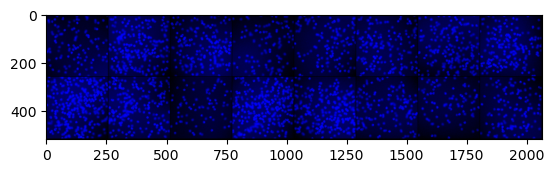

In [223]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# take a look at the test data

# Get a batch of training data
images, labels = next(iter(dataloader_test))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

print(labels)
imshow(out)

tensor([102., 156., 220., 200., 197., 178.,  74., 206., 162., 199., 143., 314.,
        212., 255., 119., 228.])


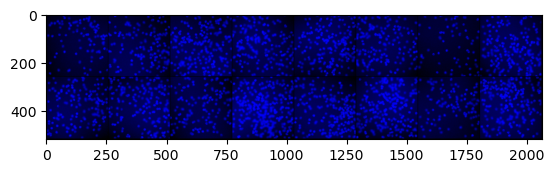

In [224]:
# take a look at the train data

# Get a batch of training data
images, labels = next(iter(dataloader_train))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

print(labels)
imshow(out)

In [251]:
class DotCounterNet(nn.Module):
    def __init__(self):
        super(DotCounterNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.dropout = nn.Dropout(0) # better results wo dropout

        self.fc1 = nn.Linear(32 * 29 * 29, 300)  
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 1)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)  
        return x

net = DotCounterNet()


In [252]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [253]:
model = net.to(device)

In [254]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 50

In [255]:
loss_l_tr, loss_l_val=[], []
l2_reg = [0, 0.001, 1e-5]

def train_model(model, dataloaders, criterion, optimizer, num_epochs, l2_strength): # , scheduler, num_epochs=25

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        

        for phase in ['train', 'val']:
            running_loss = 0.0
            
            if phase=='train':
                model.train()
            else:
                model.eval()

            for inputs, labels in dataloaders[0 if phase=='train' else 1]:
                inputs=inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1))  

                if phase=='train':

                    optimizer.zero_grad()

                    # L2 Regularization
                    if l2_strength > 0:
                        l2_reg_ = torch.tensor(0.).to(device)
                        for param in model.parameters():
                            l2_reg_ += torch.norm(param, 2)**2
                        loss += l2_strength * l2_reg_
                        
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataset_train if phase=='train' else dataset_test)

            
            if phase=='train':
                loss_l_tr.append(epoch_loss)

            else:
                loss_l_val.append(epoch_loss)


            print(f'{phase} Epoch {epoch+1}, Loss: {epoch_loss}')

    return model

model = train_model(model,
                    [dataloader_train, dataloader_test],
                       criterion,
                       optimizer,
                       num_epochs,
                       l2_reg[2]
                       )

Epoch 0/49
----------
train Epoch 1, Loss: 31002.7421875
val Epoch 1, Loss: 18175.194227430555
Epoch 1/49
----------
train Epoch 2, Loss: 5825.767957899306
val Epoch 2, Loss: 2088.428765190972
Epoch 2/49
----------
train Epoch 3, Loss: 2909.144382052951
val Epoch 3, Loss: 1951.0274183485244
Epoch 3/49
----------
train Epoch 4, Loss: 2004.3338690863716
val Epoch 4, Loss: 1671.7312961154514
Epoch 4/49
----------
train Epoch 5, Loss: 1423.7901204427083
val Epoch 5, Loss: 1225.2388814290364
Epoch 5/49
----------
train Epoch 6, Loss: 1411.0613606770833
val Epoch 6, Loss: 1162.2196756998699
Epoch 6/49
----------
train Epoch 7, Loss: 1286.4485541449653
val Epoch 7, Loss: 1052.484639485677
Epoch 7/49
----------
train Epoch 8, Loss: 1139.1917385525173
val Epoch 8, Loss: 994.738535563151
Epoch 8/49
----------
train Epoch 9, Loss: 1116.70166015625
val Epoch 9, Loss: 972.5505167643229
Epoch 9/49
----------
train Epoch 10, Loss: 1073.635057237413
val Epoch 10, Loss: 894.2389695909288
Epoch 10/49
--

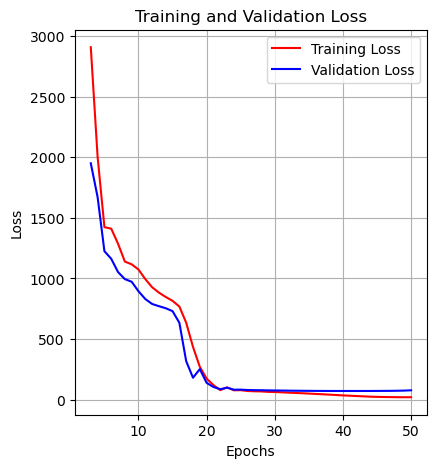

In [262]:
plt.figure(figsize=(10, 5))
epochs = range(3, num_epochs + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_l_tr[2:], 'r', label='Training Loss')
plt.plot(epochs, loss_l_val[2:], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show();